In [3]:
from itertools import product
import numpy as np
import scipy
from scipy.linalg import cho_solve
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, pairwise_distances
from sklearn.model_selection import train_test_split, KFold
from scipy.io.arff import loadarff 
import time
np.random.seed(42)

# Random Fourier Features (RFF) for Kernel Ridge Regression

## 1. Kernel Ridge Regression (KRR)
Kernel Ridge Regression solves the following optimization problem:

$$
\min_{\alpha} \|Y - K \alpha\|^2 + \lambda \|\alpha\|^2
$$

where:
- $Y$ is the target vector of shape $(n, 1)$,
- $K$ is the kernel matrix of shape $(n, n)$, defined by $K_{ij} = k(x_i, x_j)$,
- $\lambda$ is the regularization parameter,
- $\alpha$ is the vector of model coefficients.

The kernel function $k(x, z)$ for the Gaussian (RBF) kernel is defined as:

$$
k(x, z) = \exp\left(-\frac{\|x - z\|^2}{2 \sigma^2}\right)
$$

The solution to this problem is:

$$
\alpha = (K + \lambda I)^{-1} Y
$$

Given $\alpha$, predictions for a new input $x$ are:

$$
\hat{y} = \sum_{i=1}^n \alpha_i k(x, x_i)
$$

---

## 2. Motivation for Random Fourier Features
Computing the kernel matrix $K$ is expensive for large datasets, as it scales quadratically with the number of samples $n$. To approximate the kernel, we use Random Fourier Features, based on the following result:

### Bochner's Theorem
For a shift-invariant kernel $k(x, z) = k(x - z)$, there exists a probability distribution $p(\omega)$ such that:

$$
k(x, z) = \int_{\mathbb{R}^d} p(\omega) e^{j \omega^\top (x - z)} d\omega
$$

For the Gaussian kernel:

$$
k(x, z) = \exp\left(-\frac{\|x - z\|^2}{2 \sigma^2}\right)
$$

The corresponding distribution $p(\omega)$ is Gaussian:

$$
\omega \sim \mathcal{N}(0, \frac{1}{\sigma^2} I)
$$

---

## 3. Random Fourier Feature Approximation
We approximate the kernel by sampling $\omega$ from $p(\omega)$. Using Monte Carlo sampling, we can approximate $k(x, z)$ as:

$$
k(x, z) \approx \phi(x)^\top \phi(z)
$$

where $\phi(x)$ is the Random Fourier Feature mapping:

$$
\phi(x) = \sqrt{\frac{2}{D}} \cos(Wx + b)
$$

Here:
- $W$ is a matrix of random samples $\omega \sim \mathcal{N}(0, \frac{1}{\sigma^2} I)$,
- $b$ is a vector of random offsets $b \sim \text{Uniform}(0, 2\pi)$,
- $D$ is the number of random features.

---

## 4. Kernel Ridge Regression with RFF
Using the RFF mapping $\phi(x)$, we approximate the kernel matrix $K$ as:

$$
K \approx \Phi \Phi^\top
$$

where $\Phi$ is the feature matrix after applying $\phi(x)$ to all data points $X$.

### Modified Objective Function
We now rewrite the KRR optimization problem using $\Phi$:

$$
\min_w \|Y - \Phi w\|^2 + \lambda \|w\|^2
$$

where:
- $w$ is the weight vector in the transformed RFF space.

### Solution
The solution for $w$ is given by:

$$
w = (\Phi^\top \Phi + \lambda I)^{-1} \Phi^\top Y
$$

### Prediction
For a new input $x'$, the prediction is:

$$
\hat{y} = \phi(x')^\top w
$$

---

## 5. Advantages of RFF
1. **Efficiency**:
   - Avoids computing and storing the $n \times n$ kernel matrix.
   - Instead, transforms the data into an $n \times D$ feature matrix, where $D$ is typically much smaller than $n$.

2. **Scalability**:
   - Linear in $n$ for training and predictions.

3. **Flexibility**:
   - Can use any linear solver (e.g., Ridge Regression) on the transformed features.

---


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Load the dataset
data = pd.read_csv('dataset/heart_2020_cleaned.csv')

# Upsample the minority values 
minority = data[data['HeartDisease'] == 'Yes']
print(f"minority.shape: \n{minority.shape}")

for _ in range(9):
    data = pd.concat([data,minority], axis=0, ignore_index=True)

print(f"new_Data.shape: {data.shape}")    

# Apply one-hot encoding for categorical features
one_hots = pd.get_dummies(data, columns=['Sex', 'Race', 'AgeCategory', 'GenHealth'])

# Combine the original data with one-hot features
data = pd.concat([data, one_hots], axis=1).drop(columns=['Sex', 'Race', 'AgeCategory', 'GenHealth'])

# Replace binary values with 0 and 1
data = data.replace({
    'Yes': 1,
    'Yes (during pregnancy)': 1,
    'No': 0,
    'No, borderline diabetes': 0,
    True: 1,
    False: 0,
})

# # Upsample minority class 
# minority = data[data['HeartDisease'] == 1]
# print(f"mask: {minority}")
# duplicate_cols = mask.columns[mask.columns.duplicated()]
# mask.drop(columns=duplicate_cols, inplace=True)
# print(mask)
# mask = data['HeartDisease'] == 1
# print(data[mask])
# minority = np.asarray(data["HeartDisease"]==1).nonzero()
# print(f"minority: {minority}")
# print(f"minority.len: {len(minority)}")
# minority = list(np.where(data["HeartDisease"]==1)[0])
# print(f"minority: {minority}")
# print(f"minority.len: {len(minority)}")

# Shuffle and downsample the dataset
# array = data.to_numpy()[::3]  # Downsample by taking every third row
array = data.to_numpy()[::6]  # Downsample by taking every third row
np.random.shuffle(array)

# Separate features and labels
features = array[:, 1:]
labels = array[:, 0]

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
print(f"X_train.shape after downsampling: {X_train.shape}")
print(f"X_test.shape after downsampling: {X_test.shape}")

In [4]:
data = np.load('/home/youngho/Documents/csc2515/qm9_coulomb_matrix.npz', allow_pickle=True)
features = data['features']
labels = data['labels']

In [5]:
class RandomFourierFeatures:
    def __init__(self, input_dim, num_features, sigma):
        """
        Initialize the RFF transformer.
        
        Parameters:
        - input_dim: Dimensionality of the input features.
        - num_features: Number of random Fourier features (D).
        - sigma: Kernel bandwidth (scale parameter for Gaussian kernel).
        """
        self.num_features = num_features
        self.sigma = sigma
        self.W = np.random.normal(loc=0, scale=1/sigma, size=(input_dim, num_features))
        self.b = np.random.uniform(0, 2 * np.pi, size=num_features)
    
    def transform(self, X):
        """
        Transform the input features to the RFF feature space.
        
        Parameters:
        - X: Input features, shape (n_samples, input_dim).
        
        Returns:
        - Transformed features, shape (n_samples, num_features).
        """
        projection = X @ self.W + self.b
        return np.sqrt(2 / self.num_features) * np.cos(projection)


In [6]:
def KRR_with_RFF(X_train_rff, y_train, lam, num_features=500):
    """
    Kernel Ridge Regression using Random Fourier Features (RFF).
    
    Parameters:
    - X_train: Training data, shape (n_train, input_dim).
    - y_train: Training labels, shape (n_train,).
    - X_test: Test data, shape (n_test, input_dim).
    - lam: Regularization parameter (lambda).
    - sigma: Bandwidth for the Gaussian kernel.
    - num_features: Number of random Fourier features to generate.
    
    Returns:
    - Predictions on the test data.
    """
    
    # Ridge regression in transformed space
    K = X_train_rff.T @ X_train_rff + lam * np.eye(num_features)
    try:
        alphas = np.linalg.solve(K, X_train_rff.T @ y_train)
    except:
        return 'Solve failed, check pairwise distances'
    else:
        return alphas

def KRR(X_train, y_train, lam, sigma):
    """
    Kernel Ridge Regression using Random Fourier Features (RFF).
    
    Parameters:
    - X_train: Training data, shape (n_train, input_dim).
    - y_train: Training labels, shape (n_train,).
    - X_test: Test data, shape (n_test, input_dim).
    - lam: Regularization parameter (lambda).
    - sigma: Bandwidth for the Gaussian kernel.
    - num_features: Number of random Fourier features to generate.
    
    Returns:
    - Predictions on the test data.
    """
    dist = pairwise_distances(X_train)
    exponent = dist/sigma

    K = np.exp(-(exponent**2)/2)
    K += np.eye(K.shape[0])*lam
    
    try:
        alphas = np.linalg.solve(K, y_train)
    except:
        return 'Solve failed, check pairwise distances'
    else:
        return alphas

def GridSearchCV(X, Y, params, num_features, cv=4, train_set_ratio=1):
    print(params)
    kf = KFold(n_splits=cv)
    X_train, X_test = [], []
    Y_train, Y_test = [], []
    for train, test in kf.split(X):
        train_size = int(train_set_ratio*len(train))
        sampled_train = np.random.choice(train, train_size, replace=False)
        X_train.append(X[sampled_train])
        Y_train.append(Y[sampled_train])
        X_test.append(X[test])
        Y_test.append(Y[test])

    best_score = np.inf  # Maximizing accuracy
    mat = np.zeros((len(params['lambda']), len(params['length'])))
    for i, lam in enumerate(params['lambda']):
        for j, sigma in enumerate(params['length']):
            maes = []
            for k in range(cv):
                rff = RandomFourierFeatures(input_dim=X_train[k].shape[1], num_features=num_features, sigma=sigma)
        
                #alphas = KRR(X_train[k], Y_train[k], lam, sigma)
                alphas = KRR_with_RFF(rff.transform(X_train[k]), Y_train[k], lam, num_features)

                if type(alphas) == str:
                    mae = np.inf
                else:
                    # normal KRR
                    #dist = scipy.spatial.distance_matrix(X_train[k], X_test[k])
                    #exponent = dist/sigma
                #
                    #K_test = np.exp(-(exponent**2)/2)
                    #preds = K_test.T @ alphas
                    #mae = np.mean(np.abs(preds - Y_test[k]))

                    # RFF
                    X_test_rff = rff.transform(X_test[k])

                    preds = X_test_rff @ alphas
                    mae = np.mean(np.abs(preds - Y_test[k]))

                maes.append(mae)
            mat[i][j] = np.mean(maes)
            if np.mean(maes) < best_score:
                best_score = np.mean(maes)
                best_lambda = lam
                best_sigma = sigma
    
    plt.imshow(mat, cmap="viridis", interpolation="nearest")
    plt.colorbar(label="MAE")
    plt.xlabel("$\sigma$", fontsize=14)
    plt.ylabel("$\lambda$", fontsize=14)
    plt.xticks(np.arange(len(params['length'])), [f'{sigma:.2f}' for sigma in params['length']], rotation=45)
    plt.yticks(np.arange(len(params['lambda'])), [f'{lam:.2e}' for lam in params['lambda']])
    plt.title(f"Grid Search Accuracy Heatmap", fontsize=16)
    plt.show()

    return {'accuracy': best_score, 'lambda': best_lambda, 'length': best_sigma}

import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# Define hyperparameter grid
# lambdas = [1e-2, 1e-1, 1]
lambdas = np.logspace(-7, 3, num=11)
# sigmas = [0.1, 1, 10]
sigmas = np.logspace(0, 4, num=11)
num_features = 10

best_accuracy = 0
best_params = None

# Store results for plotting
repetition = 100
grid_results = np.zeros((repetition, lambdas.shape[0], sigmas.shape[0]))
print(grid_results.shape)

for r in tqdm(range(repetition)):
    for l,lam in enumerate(lambdas):
        for s,sigma in enumerate(sigmas):
            # Train and evaluate KRR with RFF
            preds = KRR(X_train, y_train, X_test, lam, sigma=)
            mae = np.mean(np.abs(preds-y_test))
            
            # print(f"Lambda: {lam}, Sigma: {sigma}, Accuracy: {accuracy}")
            
            # Append results for visualization
            # grid_results.append((lam, sigma, accuracy))
            grid_results[r,l,s] = mae
            
    # reshuffle dataset 
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels)

# average over repetitions to calculate the mean accuarcy
mean_accuracy = np.mean(grid_results, axis=0)
max_acc = 0

for l in range(len(lambdas)):
    for s in range(len(sigmas)):
        if mean_accuracy[l,s] > max_acc:
            max_acc = mean_accuracy[l,s] 
            best_lambda = l
            best_sigma = s

print(f"best_lambda:{best_lambda}\nbest_sigma:{best_sigma}\nbest_acc:{max_acc}")

# print(f"Best Parameters: {best_params}, Best Accuracy: {best_accuracy}")

# # Convert grid results to a structured array for easy plotting
# results_array = np.array(grid_results)
# lambdas_unique = np.unique(results_array[:, 0])
# sigmas_unique = np.unique(results_array[:, 1])

# # Create accuracy matrix for heatmap
# accuracy_matrix = np.zeros((len(lambdas_unique), len(sigmas_unique)))
# for i, lam in enumerate(lambdas_unique):
#     for j, sigma in enumerate(sigmas_unique):
#         match = results_array[(results_array[:, 0] == lam) & (results_array[:, 1] == sigma)]
#         if len(match) > 0:
#             accuracy_matrix[i, j] = match[0, 2]

# # Plotting as a heatmap

# Use LateX for text rendering
plt.rc('text', usetex=False) # usetex = True
plt.figure(figsize=(8, 6))
plt.imshow(mean_accuracy, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Accuracy")
# plt.xticks(range(len(sigmas_unique)), sigmas_unique, rotation=45)
# Only show 1, 100, 10000 for sigma
plt.xticks([0, 5, 10], [1, 100, 10000])
plt.yticks(range(len(lambdas)), lambdas)
plt.xlabel("$\sigma$", fontsize=14)
plt.ylabel("$\lambda$", fontsize=14)
plt.title(f"Grid Search Accuracy Heatmap for $n = {num_features}$", fontsize=16)
plt.savefig("grid_search_heatmap.pdf")
plt.show()

Training size 6541.55
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


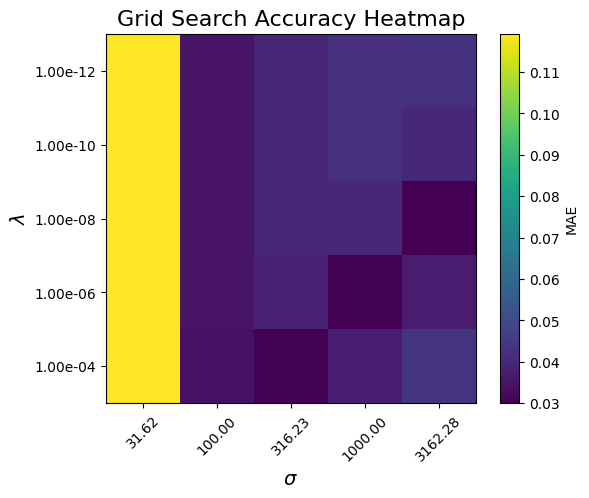

{'accuracy': np.float64(0.02998349327707525), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 2.7955846786499023, test kernel 522.3508117198944
Training size 13083.1
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


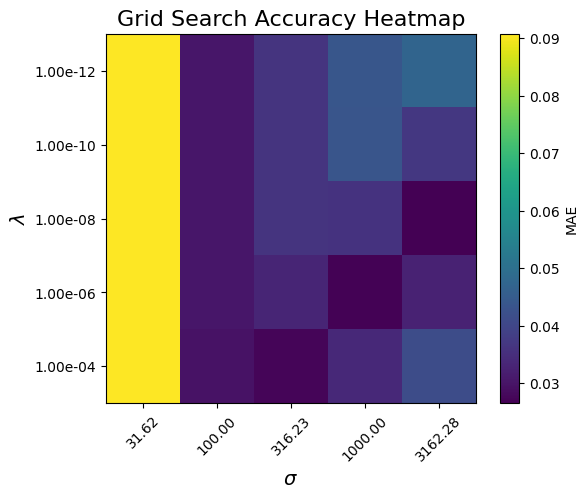

{'accuracy': np.float64(0.02645862325482564), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}


In [29]:
training_fractions = [0.05, 0.1, 0.2, 0.4, 0.8]
test_size = int((1-max(training_fractions))*len(features))

N = 2
all_maes = []

time_to_invert = np.zeros((N,len(training_fractions)))
time_to_predict = np.zeros((N,len(training_fractions)))

for n in range(N):
    indices = list(range(len(features)))
    np.random.shuffle(indices)
    
    X = features[indices]
    Y = labels[indices]

    X_test = X[-test_size:]
    Y_test = Y[-test_size:]

    X_trains, Y_trains, = [], []

    for frac in training_fractions:
        training_size = int(frac*len(X))
        X_trains.append(X[:training_size])
        Y_trains.append(Y[:training_size])

    maes = []
    
    for i in range(len(training_fractions)):
        print(f'Training size {training_fractions[i]*len(X)}')
        X_train = X_trains[i]
        Y_train = Y_trains[i]

        param_grid = {'length': np.logspace(1.5, 3.5, num=5),
                    'lambda': np.logspace(-12, -4, num=5)}
        best_params = GridSearchCV(X_train, Y_train, param_grid, 4, 0.5)
        print(best_params)

        #rff = RandomFourierFeatures(input_dim=X_train.shape[1], num_features=num_features, sigma=sigma)

        begin = time.time()
        alphas = KRR(X_train, Y_train, best_params['lambda'], best_params['length'])
        # alphas = KRR_with_RFF(rff.transform(X_train), Y_train, best_params['lambda'], num_features)
        end = time.time()
        kernel_inversion = end - begin
        time_to_invert[n,i] = end - begin

        # normal KRR
        begin2 = time.time()
        dist = scipy.spatial.distance_matrix(X_test,X_train)
        exponent = dist/best_params['length']
        K_test = np.exp(-(exponent**2)/2)
        preds = np.dot(K_test,alphas)
        end2 = time.time()
        pred_time = end2 - begin2
        time_to_predict[n,i] = end2 - begin2

        maes.append(np.mean(np.abs(preds - Y_test)))

        # RFF
        #begin2 = time.time()
        #rff = RandomFourierFeatures(input_dim=X_train.shape[1], num_features=num_features, sigma=best_params['length'])
        #X_test_rff = rff.transform(X_test)
        #preds = X_test_rff @ alphas
        #end2 = time.time()
        #pred_time = end2 - begin2

        #mae = np.mean(np.abs(preds - Y_test))
        print(f'Kernel inversion took {kernel_inversion}, predictions {pred_time}')                                                                                       

all_maes.append(maes)

In [13]:
def measure_time(features, labels, N, method, num_features=None):
    training_fractions = [0.05, 0.1, 0.2, 0.4]
    test_size = int((1-max(training_fractions))*len(features))

    # N = 2
    all_maes = []

    time_to_invert = np.zeros((N,len(training_fractions)))
    time_to_predict = np.zeros((N,len(training_fractions)))
    maes = np.full((N,len(training_fractions)), np.inf, dtype=np.float32)

    for n in range(N):
        indices = list(range(len(features)))
        np.random.shuffle(indices)
        
        X = features[indices]
        Y = labels[indices]

        X_test = X[-test_size:]
        Y_test = Y[-test_size:]

        X_trains, Y_trains, = [], []

        for frac in training_fractions:
            training_size = int(frac*len(X))
            X_trains.append(X[:training_size])
            Y_trains.append(Y[:training_size])

       
        
        for i in range(len(training_fractions)):

            print(f'Training size {training_fractions[i]*len(X)}')
            X_train = X_trains[i]
            Y_train = Y_trains[i]

            param_grid = {'length': np.logspace(1.5, 3.5, num=5),
                        'lambda': np.logspace(-12, -4, num=5)}
            best_params = GridSearchCV(X_train, Y_train, param_grid,num_features, 4, 0.5)
            print(best_params)

            
            if method == 'KRR':
                begin = time.time()
                alphas = KRR(X_train, Y_train, best_params['lambda'], best_params['length'])
                end = time.time()
                time_to_invert[n,i] = end - begin

                # normal KRR
                begin2 = time.time()
                dist = scipy.spatial.distance_matrix(X_test,X_train)
                exponent = dist/best_params['length']
                K_test = np.exp(-(exponent**2)/2)
                preds = np.dot(K_test,alphas)
                end2 = time.time()
                pred_time = end2 - begin2
                time_to_predict[n,i] = end2 - begin2

                print(f'Kernel inversion took {kernel_inversion}, predictions {pred_time}') 

                maes[n,i] = np.mean(np.abs(preds - Y_test))


            elif method == 'RFF':
                if num_features is None:
                    print("you forgot num_features")
                    return
                rff = RandomFourierFeatures(input_dim=X_train.shape[1], num_features=num_features, sigma=best_params['length'])

                begin = time.time()
                alphas = KRR_with_RFF(rff.transform(X_train), Y_train, best_params['lambda'], num_features)
                end = time.time()
                kernel_inversion = end-begin
                time_to_invert[n,i] = end - begin

                # RFF
                begin2 = time.time()
                X_test_rff = rff.transform(X_test)
                preds = X_test_rff @ alphas
                end2 = time.time()
                pred_time = end2-begin2
                time_to_predict[n,i] = end2 - begin2

                print(f'Kernel inversion took {kernel_inversion}, predictions {pred_time}') 
                maes[n,i] = np.mean(np.abs(preds - Y_test)) 

            else:
                print("please select correct method")
                return
            
            # kernel_inversion = end - begin
            
    if method == 'KRR':
        np.savez('time_diff/KRR.npz', maes=maes, time_to_invert=time_to_invert, time_to_predict=time_to_predict)

            
    else:
        np.savez('time_diff/RFF_n'+str(num_features) +'.npz', maes=maes, time_to_invert=time_to_invert, time_to_predict=time_to_predict)

            
    return maes, time_to_invert, time_to_predict
            #mae = np.mean(np.abs(preds - Y_test))
            # print(f'Kernel inversion took {kernel_inversion}, predictions {pred_time}')      

In [ ]:
maes, time_to_invert, time_to_predict = measure_time(features, labels, N=2, method='RFF', num_features=100) # Richard

Training size 6541.55
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


Training size 6541.55
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


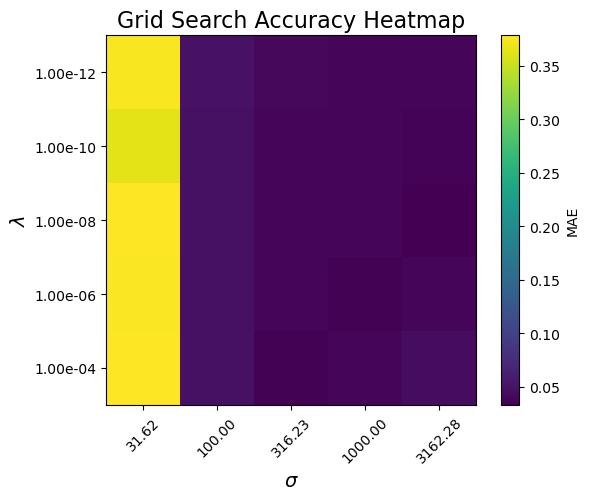

{'accuracy': np.float64(0.0329378497250166), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 0.18972063064575195, predictions 0.7987351417541504
Training size 13083.1
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


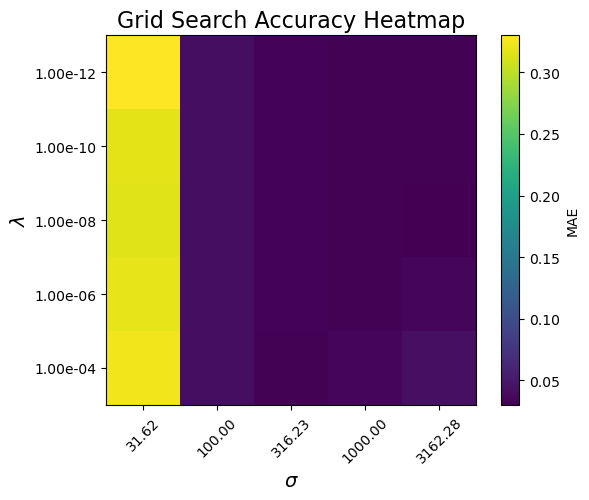

{'accuracy': np.float64(0.03004030160343916), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 0.34677791595458984, predictions 0.7960219383239746
Training size 26166.2
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


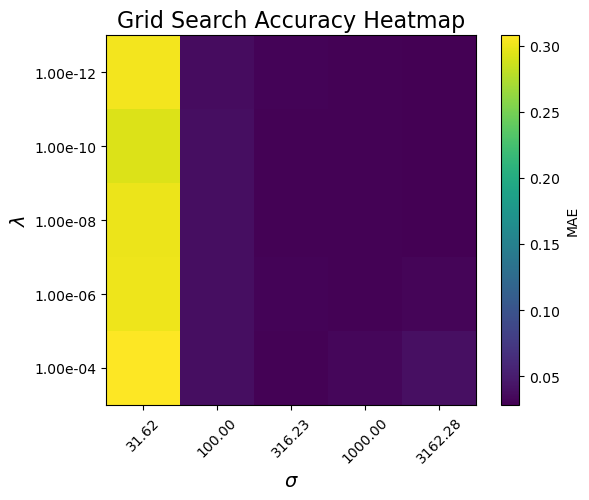

{'accuracy': np.float64(0.02835070671501814), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 0.6009962558746338, predictions 0.7909591197967529
Training size 52332.4
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


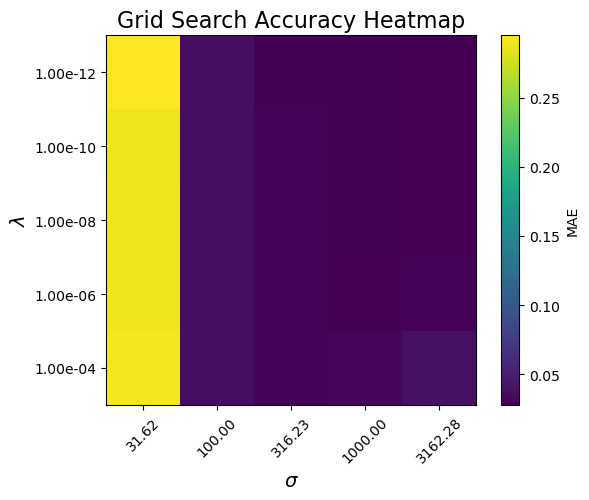

{'accuracy': np.float64(0.02775473894161666), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 1.095628023147583, predictions 0.7874288558959961
Training size 6541.55
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


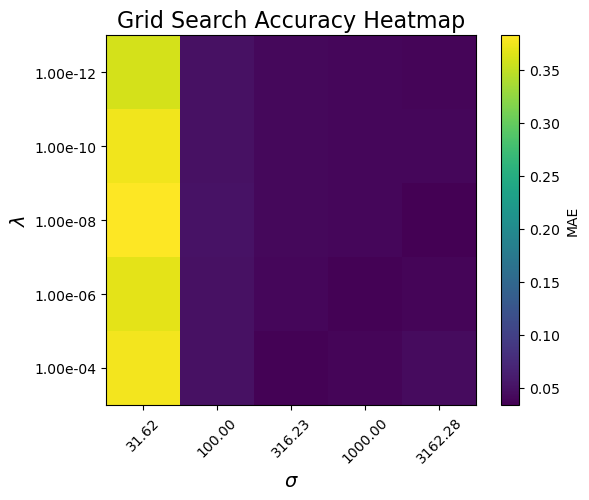

{'accuracy': np.float64(0.033696681998594026), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 0.1925983428955078, predictions 0.795989990234375
Training size 13083.1
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


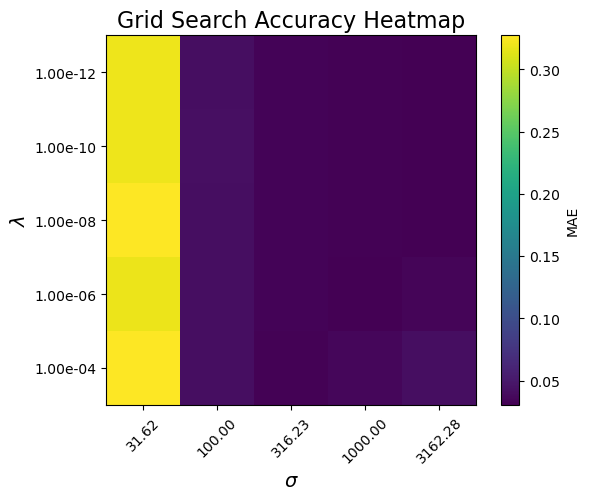

{'accuracy': np.float64(0.030283669344283996), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 0.35196638107299805, predictions 0.8011934757232666
Training size 26166.2
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


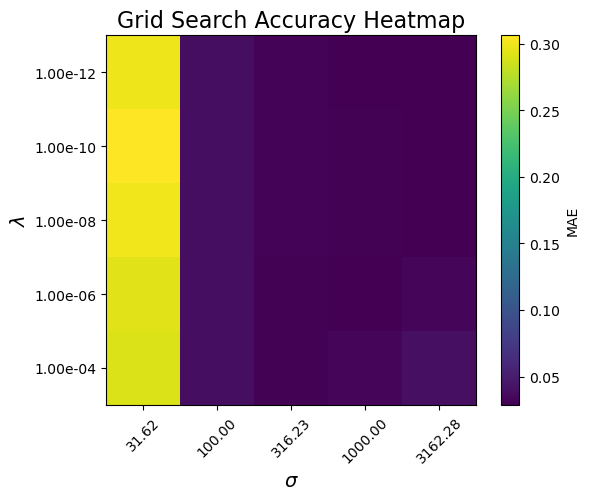

{'accuracy': np.float64(0.028751244289555625), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 0.5965926647186279, predictions 0.7969319820404053
Training size 52332.4
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


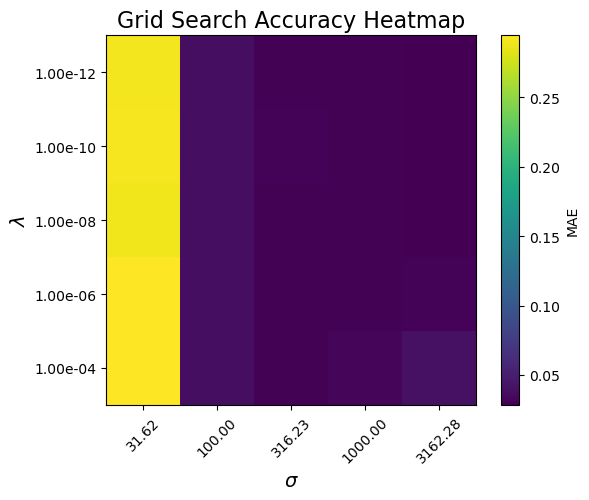

{'accuracy': np.float64(0.028246120288338783), 'lambda': np.float64(1e-10), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 1.1062366962432861, predictions 0.8169293403625488
Training size 6541.55
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


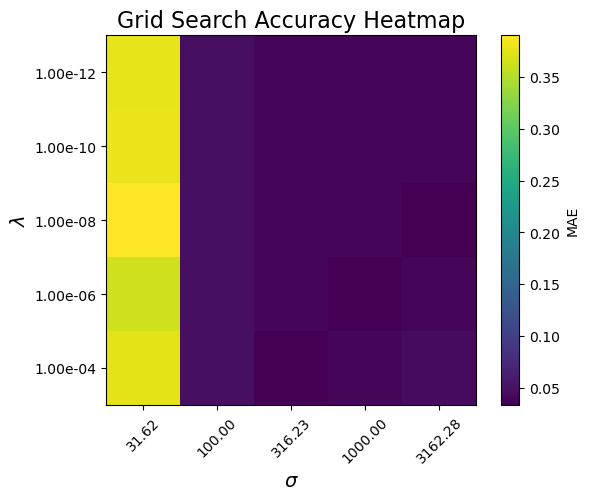

{'accuracy': np.float64(0.03330800448189673), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 0.20628786087036133, predictions 0.8163774013519287
Training size 13083.1
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


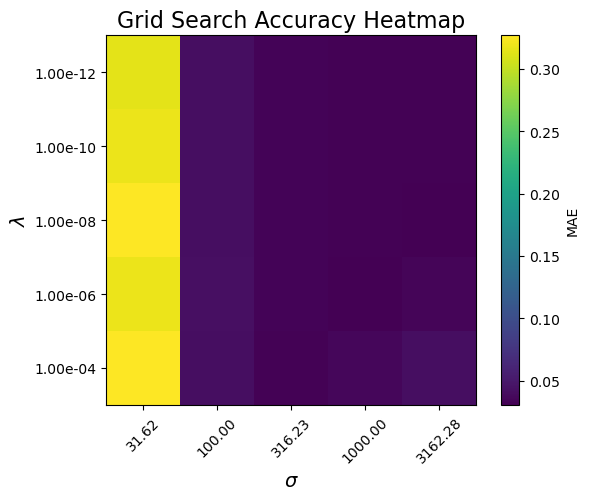

{'accuracy': np.float64(0.030525100481157336), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 0.34148287773132324, predictions 0.7837154865264893
Training size 26166.2
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


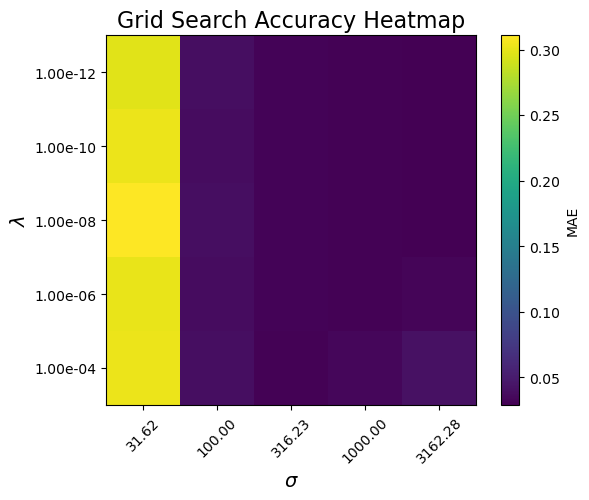

{'accuracy': np.float64(0.028772717513127797), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 0.5961825847625732, predictions 0.7928025722503662
Training size 52332.4
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


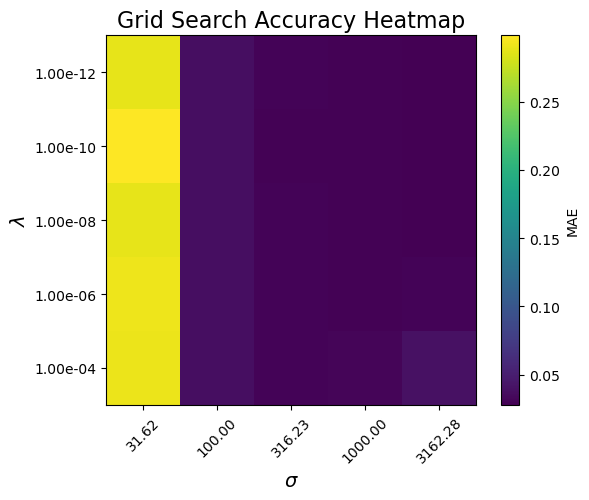

{'accuracy': np.float64(0.02776271212385239), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 1.0905184745788574, predictions 0.7960367202758789
Training size 6541.55
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


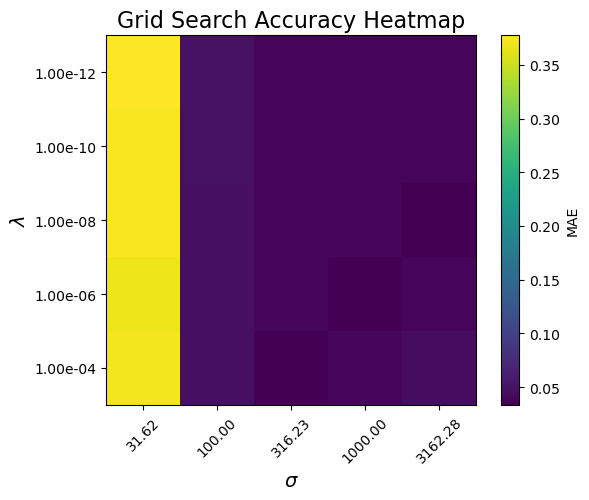

{'accuracy': np.float64(0.03335952418908269), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 0.2113492488861084, predictions 0.8204092979431152
Training size 13083.1
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


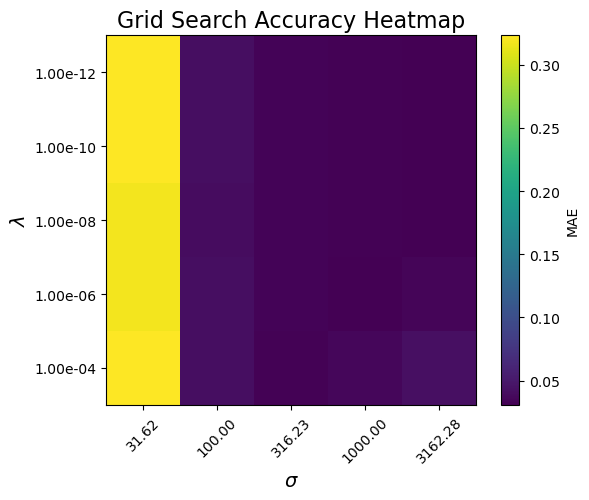

{'accuracy': np.float64(0.03053851219660669), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 0.33939146995544434, predictions 0.7934300899505615
Training size 26166.2
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


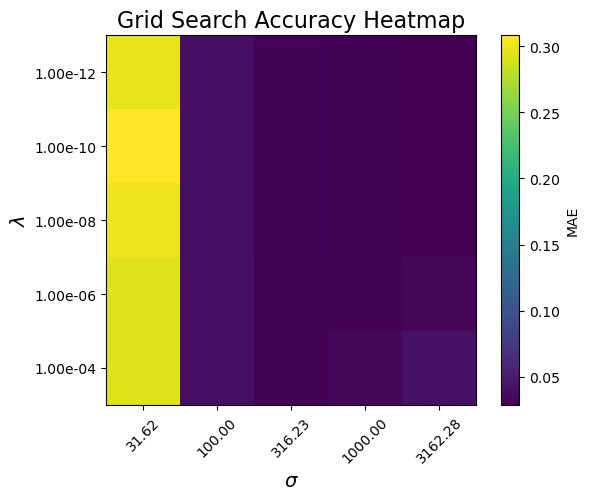

{'accuracy': np.float64(0.028593118605105893), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 0.5824799537658691, predictions 0.8038051128387451
Training size 52332.4
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


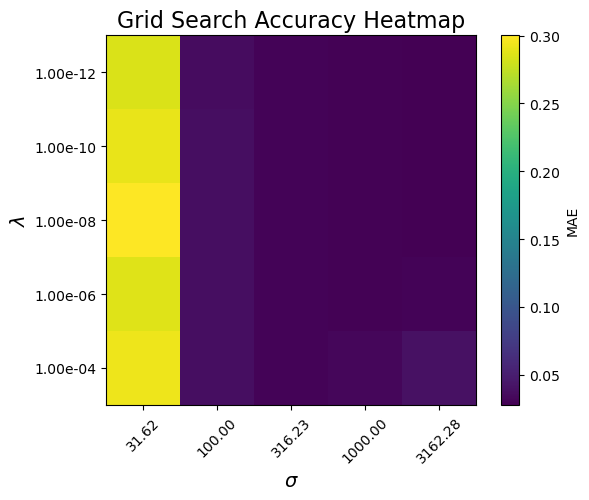

{'accuracy': np.float64(0.02771569147829949), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 1.0912754535675049, predictions 0.7851905822753906
Training size 6541.55
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


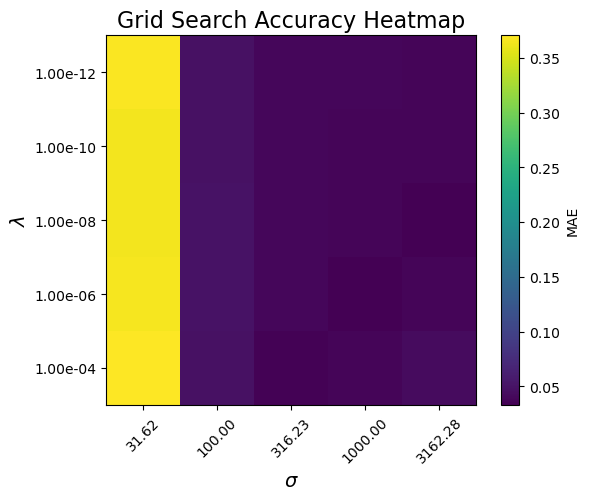

{'accuracy': np.float64(0.03273380530729988), 'lambda': np.float64(1e-08), 'length': np.float64(3162.2776601683795)}
Kernel inversion took 0.21053695678710938, predictions 0.7851083278656006
Training size 13083.1
{'length': array([  31.6227766 ,  100.        ,  316.22776602, 1000.        ,
       3162.27766017]), 'lambda': array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])}


In [14]:
maes, time_to_invert, time_to_predict = measure_time(features, labels, N=10, method='RFF', num_features=1000) # Scott

In [ ]:
maes, time_to_invert, time_to_predict = measure_time(features, labels, N=2, method='KRR') # Karthik

/tmp/ipykernel_26386/3050205265.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


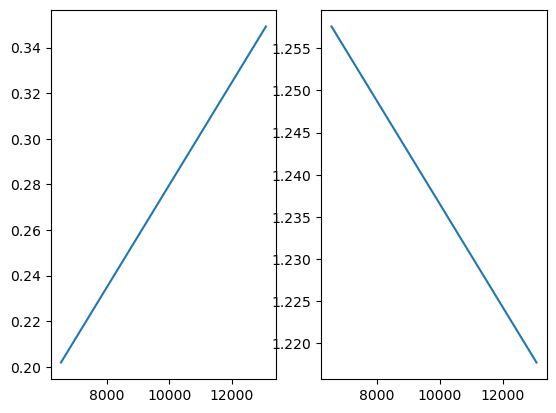

In [43]:
time_to_invert = np.mean(time_to_invert, axis=0)
time_to_predict = np.mean(time_to_predict, axis=0)
training_fractions = np.array([0.05, 0.1])#, 0.2, 0.4, 0.8]
training_size = training_fractions*len(features)

fig, axs = plt.subplots(1,2)
axs[0].plot(training_size, time_to_invert)
axs[1].plot(training_size, time_to_predict)
fig.show()

  0%|          | 0/100 [00:00<?, ?it/s]

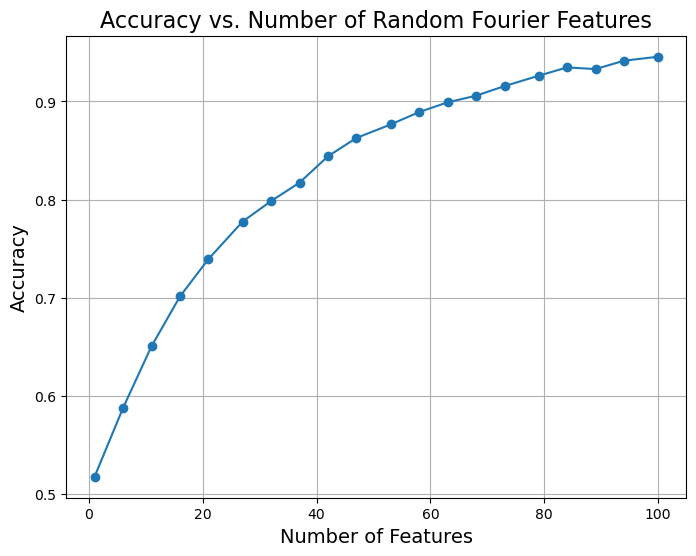

In [9]:
# Pick the best parameters
# best_lambda = best_params['lambda']
# best_sigma = best_params['sigma']


# Train and evaluate  and plot for different number of features
num_features_list = np.linspace(1, 100, num=20, dtype=int)
accuracies = np.zeros((repetition, num_features_list.shape[0]))
repetition = 100
for r in tqdm(range(repetition)):
    for n,num_features in enumerate(num_features_list):
        preds = KRR_with_RFF(X_train, y_train, X_test, best_lambda, best_sigma, num_features=num_features)
        accuracy = accuracy_score(y_test, preds)
        accuracies[r,n] = accuracy
        # print(f"Number of Features: {num_features}, Accuracy: {accuracy}")
    # reshuffle dataset 
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels)
    
mean_accuracy = accuracies.mean(axis=0)        

# Plot the results
plt.rc('text', usetex=False) #usetex=True
plt.figure(figsize=(8, 6))
plt.plot(num_features_list, mean_accuracy, marker='o')
# plt.xscale('log')
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs. Number of Random Fourier Features", fontsize=16)
plt.grid(True)
plt.savefig('accuracy_vs_num_features.png')
plt.show()



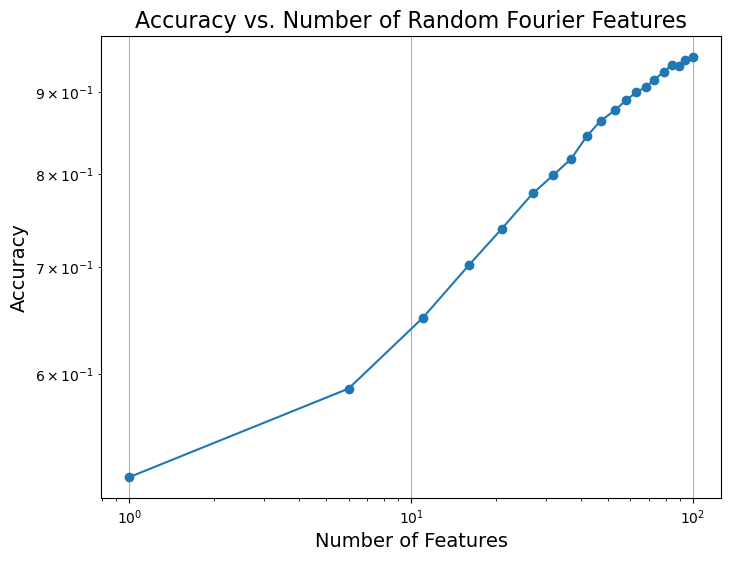

In [10]:
# Plot the results
plt.rc('text', usetex=False) #usetex=True
plt.figure(figsize=(8, 6))
plt.loglog(num_features_list, mean_accuracy, marker='o')
# plt.xscale('log')
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs. Number of Random Fourier Features", fontsize=16)
plt.grid(True)
plt.savefig('accuracy_vs_num_features_loglog.png')
plt.show()


In [ ]:
X_train.shape, X_test.shape

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/hf/xpg67mrx1vjb7hzv3ym5m07c0000gn/T/ipykernel_58214/2051215337.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/hf/xpg67mrx1vjb7hzv3ym5m07c0000gn/T/ipykernel_58214/2051215337.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/hf/xpg67mrx1vjb7hzv3ym5m07c0000gn/T/ipykernel_58214/2051215337.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/hf/xpg67mrx1vjb7hzv3ym5m07c0000gn/T/ipykernel_58214/2051215337.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


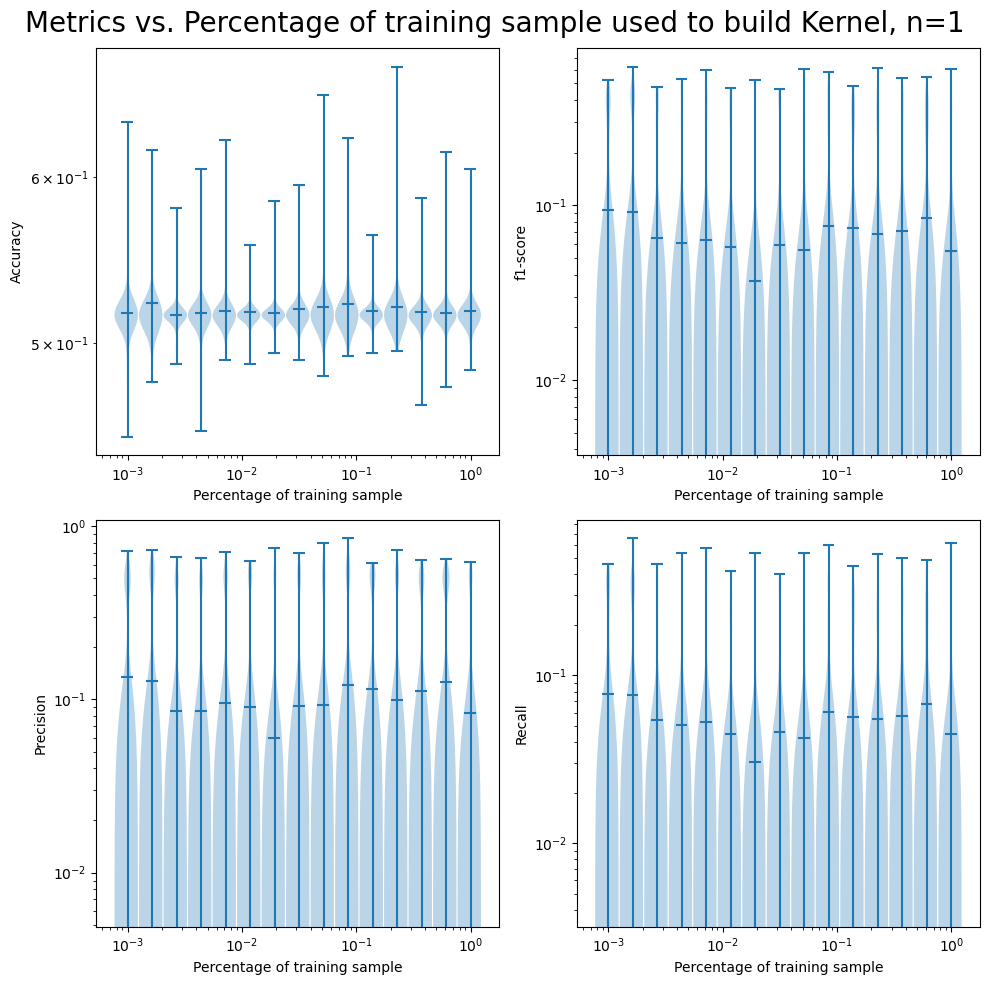

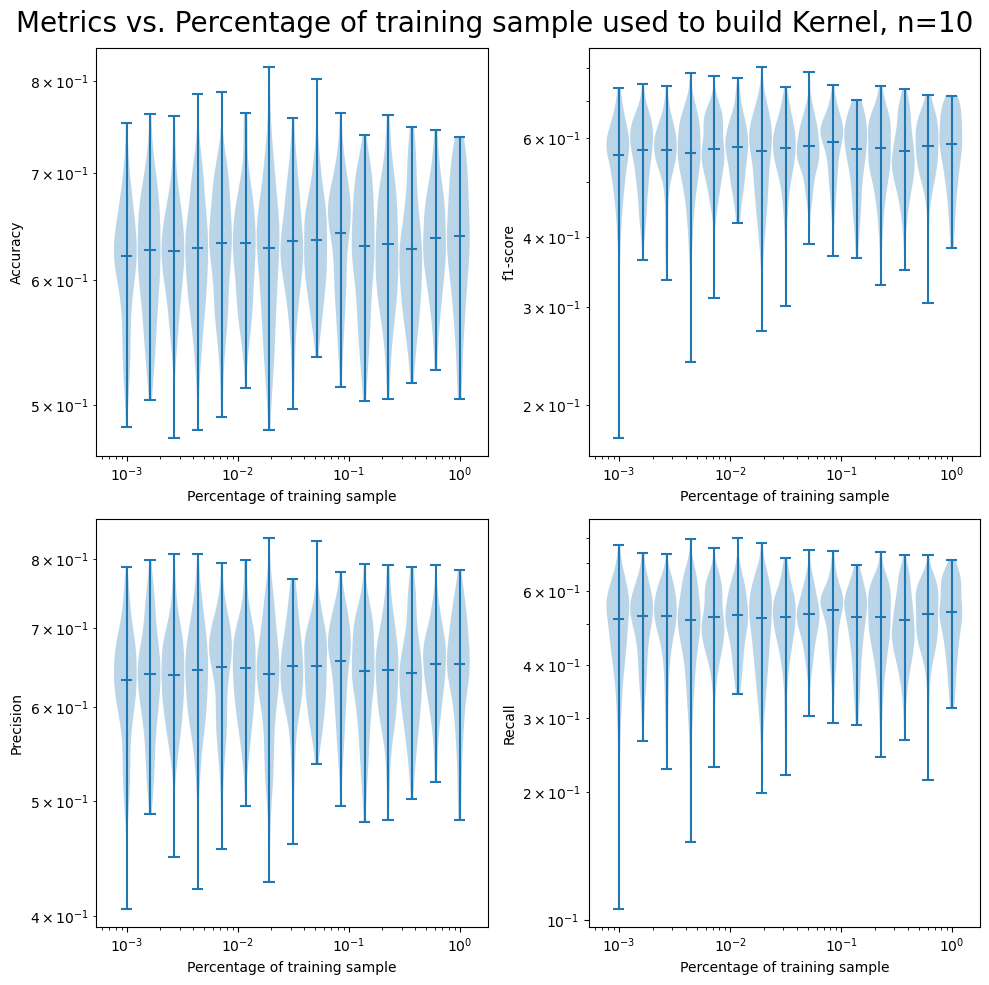

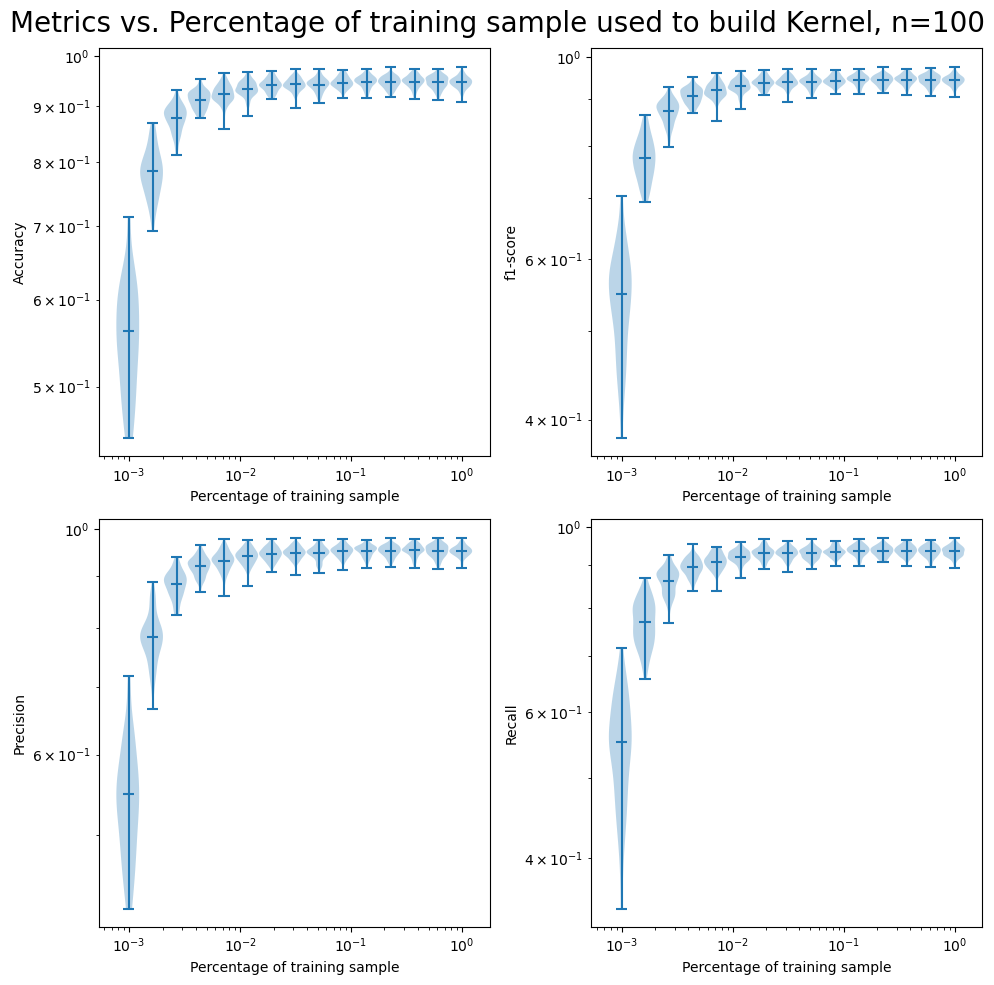

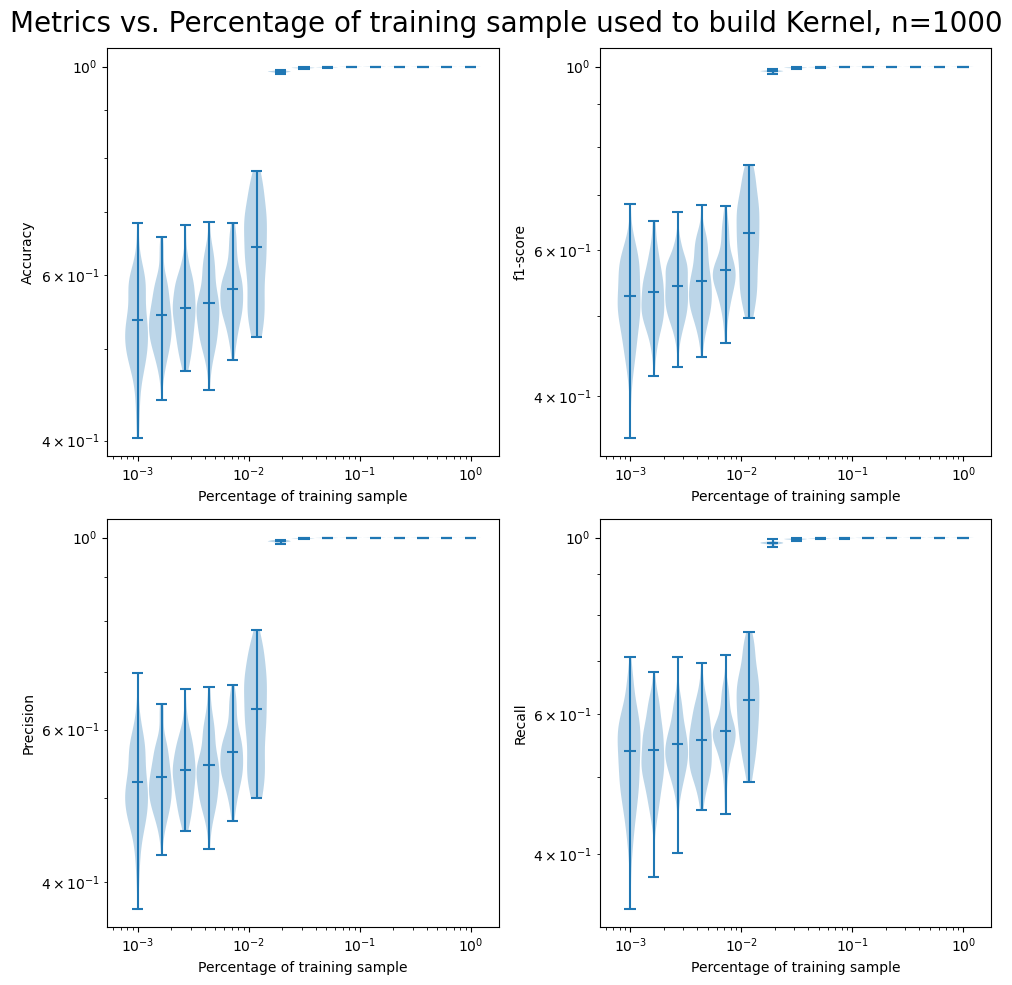

In [11]:
# learning curve for various number of train samples
from math import floor
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)


fraction = np.logspace(-3, 0, num=15, endpoint=True)
num_features= [1, 10, 100, 1000]
repetition = 100

for num_feature in num_features:
    accuracies = np.zeros((repetition,len(fraction)))
    precision = np.zeros((repetition,len(fraction)))
    recall = np.zeros((repetition, len(fraction)))
    f1 = np.zeros((repetition, len(fraction)))
    for r in tqdm(range(repetition)):
        for i,frac in enumerate(fraction):
            N = floor(X_train.shape[0]*frac)
            x_train = X_train[:N,:]
            y_t = y_train[:N]
            preds = KRR_with_RFF(x_train, y_t, X_test, lam= best_lambda, sigma=best_sigma, num_features=num_feature) # best lam and sigma
            accuracies[r,i] = accuracy_score(y_test, preds)
            precision[r,i] = precision_score(y_test, preds)
            recall[r,i] = recall_score(y_test, preds) 
            f1[r,i] = f1_score(y_test, preds)
        # reshuffle dataset 
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels)
        
    accuracies_list = [accuracies[:,i] for i in range(len(fraction))]
    f1_list = [f1[:,i] for i in range(len(fraction))]
    precision_list = [precision[:,i] for i in range(len(fraction))]
    recall_list = [recall[:,i] for i in range(len(fraction))]

    w = 0.2
    width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

    fig,axs = plt.subplots(2,2, figsize=(10,10), tight_layout=True)
    # fig.tight_layout()
    fig.suptitle("Metrics vs. Percentage of training sample used to build Kernel, n=" + str(num_feature), fontsize=20)
    # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    axs[0,0].violinplot(dataset=accuracies_list, positions=fraction, showmeans=True, points=repetition, widths=width(fraction,w))
    axs[0,0].set_xscale('log')
    axs[0,0].set_yscale('log')
    axs[0,0].set_xlabel("Percentage of training sample")
    axs[0,0].set_ylabel("Accuracy")
    axs[0,1].violinplot(dataset=f1_list, positions=fraction, showmeans=True, points=repetition, widths=width(fraction,w))
    axs[0,1].set_xscale('log')
    axs[0,1].set_yscale('log')
    axs[0,1].set_xlabel("Percentage of training sample")
    axs[0,1].set_ylabel("f1-score") 
    axs[1,0].violinplot(dataset=precision_list, positions=fraction, showmeans=True, points=repetition, widths=width(fraction,w))
    axs[1,0].set_xscale('log')
    axs[1,0].set_yscale('log')
    axs[1,0].set_xlabel("Percentage of training sample")
    axs[1,0].set_ylabel("Precision")
    axs[1,1].violinplot(dataset=recall_list, positions=fraction, showmeans=True, points=repetition, widths=width(fraction,w))
    axs[1,1].set_xscale('log')
    axs[1,1].set_yscale('log')
    axs[1,1].set_xlabel("Percentage of training sample")
    axs[1,1].set_ylabel("Recall")
    fig.show()
    fig.savefig("training_size_sweep_n" + str(num_feature)+".png")
